In [42]:
# dataframe manipulations
import pandas as pd

#math
from scipy.sparse import csr_matrix
import numpy as np

#images
from IPython.display import display
from PIL import Image


#Data viz
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity 


In [43]:
book_base = pd.read_csv('data/Books.csv',on_bad_lines='error',encoding='latin-1')
#book_base = pd.read_csv('https://raw.githubusercontent.com/ashima96/Book-Recommendation-System/master/Datasets/Books.csv', encoding='latin-1')
user_base = pd.read_csv('data/Users.csv',on_bad_lines='error',encoding='latin-1')
rate_base = pd.read_csv('data/Ratings.csv',on_bad_lines='error',encoding='latin-1')

/tmp/ipykernel_23117/430174367.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_base = pd.read_csv('data/Books.csv',on_bad_lines='error',encoding='latin-1')


## DA

In [44]:
print(f'book possui {book_base.shape[0]} linhas e {book_base.shape[1]} colunas')
print(f'user possui {user_base.shape[0]} linhas e {user_base.shape[1]} colunas')
print(f'rate possui {rate_base.shape[0]} linhas e {rate_base.shape[1]} colunas')

book possui 271360 linhas e 8 colunas
user possui 278858 linhas e 3 colunas
rate possui 1149780 linhas e 3 colunas


### Books dataset

In [45]:
book_base.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


Vamos retirar algumas colunas do dataset `book_base`


In [46]:
books = book_base.drop(columns=['Image-URL-S', 'Image-URL-M'])

In [47]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...


Para facilitar a manipulação dos dados, irei renomear algumas colunas

In [48]:
books = books.rename(columns={
    'Book-Title' : 'title',
    'Book-Author': 'author',
    'Year-Of-Publication': 'year',
    'Publisher': 'publisher'   
    
})

In [49]:
books.head(2)

,ISBN,title,author,year,publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...


In [50]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         271360 non-null  object
 1   title        271360 non-null  object
 2   author       271359 non-null  object
 3   year         271360 non-null  object
 4   publisher    271358 non-null  object
 5   Image-URL-L  271357 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


### User dataset

In [51]:
user_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [52]:
user_base.shape

(278858, 3)

In [53]:
user = user_base

In [54]:
user.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [55]:
user = user.rename(columns={
    'User-ID':'user-id',
    'Location':'location',
    'Age':'age'
    
})

In [56]:
user.head(2)

,user-id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


### Rating

In [57]:
rate_base.shape

(1149780, 3)

In [58]:
rate_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [59]:
rate_base['User-ID'] = rate_base['User-ID'].astype('object')

In [60]:
rating= rate_base

In [61]:
rating['Book-Rating'].value_counts().sort_values(ascending = False)

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

In [62]:
rating = rating.rename(columns={
    'User-ID':'user-id',
    'Book-Rating':'rating'
    
})

###  Top 5 usuários que mais avaliaram Quantidade de avaliações por usuário

In [63]:
rating['user-id'].value_counts()[:5]


11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: user-id, dtype: int64

In [64]:
top5 = rating['user-id'].value_counts()[:5].reset_index().rename(columns = {'index':'number_review'})

In [65]:
top5 = top5.sort_values(by = 'number_review', ascending = False);top5

,number_review,user-id
1,198711,7550
2,153662,6109
3,98391,5891
4,35859,5850
0,11676,13602


<AxesSubplot:xlabel='user-id', ylabel='number_review'>

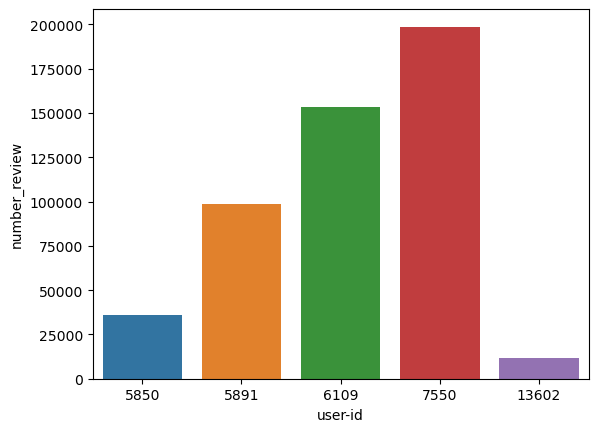

In [66]:
sns.barplot(data = top5, x = 'user-id', y = 'number_review')

## Filtragem de atributos

Neste momento faremos uma filtragem nos dados, com fito de facilitar a implementação do algorítimo adiante

Como vimos acima, na sessão em que manipulei o dataset `Rating`, temos muitos usuários com poucas avaliações, e isto pode nos gerar um problema no nosso sistema de recomendação. Por tanto, como decisão de negócio iremos filtrar estes clientes 

### Queremos apenas os usuários com <b>mais de 200 avaliações</b>

In [67]:
x = rating['user-id'].value_counts() > 200 ; x

11676      True
198711     True
153662     True
98391      True
35859      True
          ...  
116180    False
116166    False
116154    False
116137    False
276723    False
Name: user-id, Length: 105283, dtype: bool

In [68]:
# x em um dataframe
x = x.reset_index()
#selecionando apenas as colunas verdadeiras
x = x.loc[x['user-id'] == True];
# lista de usuários
user_idx = x['index'].tolist()

In [69]:
ratings = rating[rating['user-id'].isin(user_idx)];
ratings

,user-id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0
...,...,...,...
1147612,275970,3829021860,0
1147613,275970,4770019572,0
1147614,275970,896086097,0
1147615,275970,9626340762,8


Conseguimos os usuários que se enquadram nesta decisão de negócio

### Apartir disso, temos como descobrir os nomes dos livros avaliados por cada usuário, a partir de seu identificador `ISBN`

In [70]:
ratings_books = ratings.merge(books,on = 'ISBN'); ratings_books.head()

,user-id,ISBN,rating,title,author,year,publisher,Image-URL-L
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...


In [71]:
ratings_books.shape

(487671, 8)

## Livro x Rating


In [72]:
#agrupando Livros x Rating
num_rating = ratings_books.groupby('title')['rating'].count().reset_index();
#renomeando a coluna Rating para num_rating
num_rating.rename(columns={'rating':'num_ratings'},inplace = True);num_rating

,title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1
...,...,...
160264,Ã?Ã?ber die Pflicht zum Ungehorsam gegen den...,3
160265,Ã?Ã?lpiraten.,1
160266,Ã?Ã?rger mit Produkt X. Roman.,1
160267,Ã?Ã?stlich der Berge.,1


In [73]:
# Titulos com mais de 50 avaliações
num_rating_over50 = num_rating.sort_values(by='num_ratings',ascending=False)
num_rating_over50 = num_rating_over50.loc[num_rating_over50['num_ratings']>50]; num_rating_over50

,title,num_ratings
156313,Wild Animus,363
19140,Bridget Jones's Diary,277
130224,The Lovely Bones: A Novel,270
132891,The Notebook,241
133898,The Pelican Brief,236
...,...,...
41255,Eyes of a Child,51
85885,Nothing Lasts Forever,51
114155,Tell Me Your Dreams,51
73408,Lucky Man: A Memoir,51


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Wild Animus'),
  Text(1, 0, "Bridget Jones's Diary"),
  Text(2, 0, 'The Lovely Bones: A Novel'),
  Text(3, 0, 'The Notebook'),
  Text(4, 0, 'The Pelican Brief')])

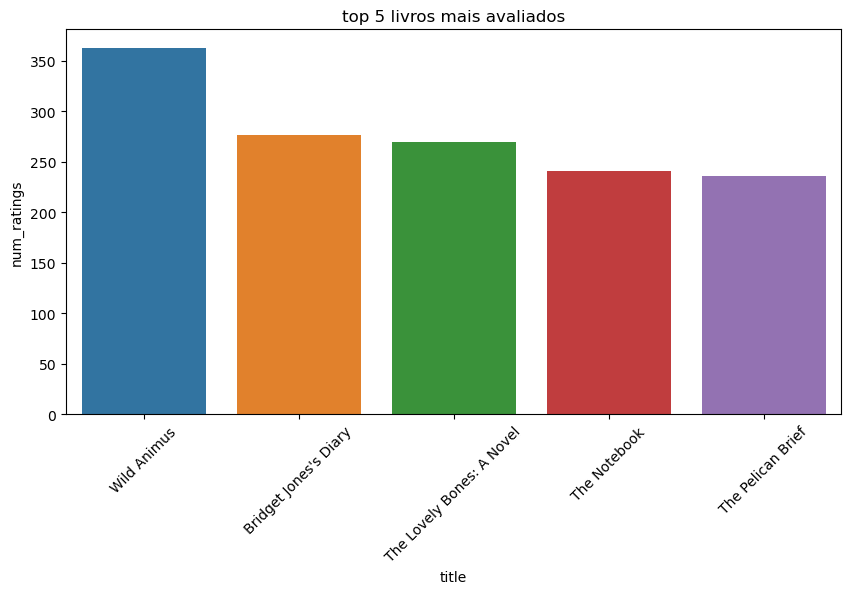

In [74]:
plt.figure(figsize=(10,5))
sns.barplot(data = num_rating_over50[:5], x = 'title', y = 'num_ratings')
plt.title('top 5 livros mais avaliados')
plt.xticks(rotation = 45)

Com este novo atributo `num_ratings` vamos adiciona-lo à tabela de `rating_books` e formar uma tabela completa das features necessárias para o modelo

In [75]:
final_rating = ratings_books.merge(num_rating_over50, on='title'); final_rating

,user-id,ISBN,rating,title,author,year,publisher,Image-URL-L,num_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
...,...,...,...,...,...,...,...,...,...
59898,127233,0061090956,0,Still Waters,Kerry Tucker,1992,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061090956.0...,83
59899,262399,0061090956,0,Still Waters,Kerry Tucker,1992,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061090956.0...,83
59900,178667,074350996X,0,Still Waters,Jennifer Lauck,2001,Simon &amp; Schuster Audio,http://images.amazon.com/images/P/074350996X.0...,83
59901,185233,074350996X,0,Still Waters,Jennifer Lauck,2001,Simon &amp; Schuster Audio,http://images.amazon.com/images/P/074350996X.0...,83


In [76]:
final_rating.drop_duplicates(['user-id','title'],inplace=True); final_rating.shape

(57952, 9)

## Filtro colaborativo

### TEXTO FITLRO COLABORATIVO

**Como Funciona um Sistema de Recomendação**
https://www.youtube.com/live/mtRIGq4nSu4?feature=share&t=721

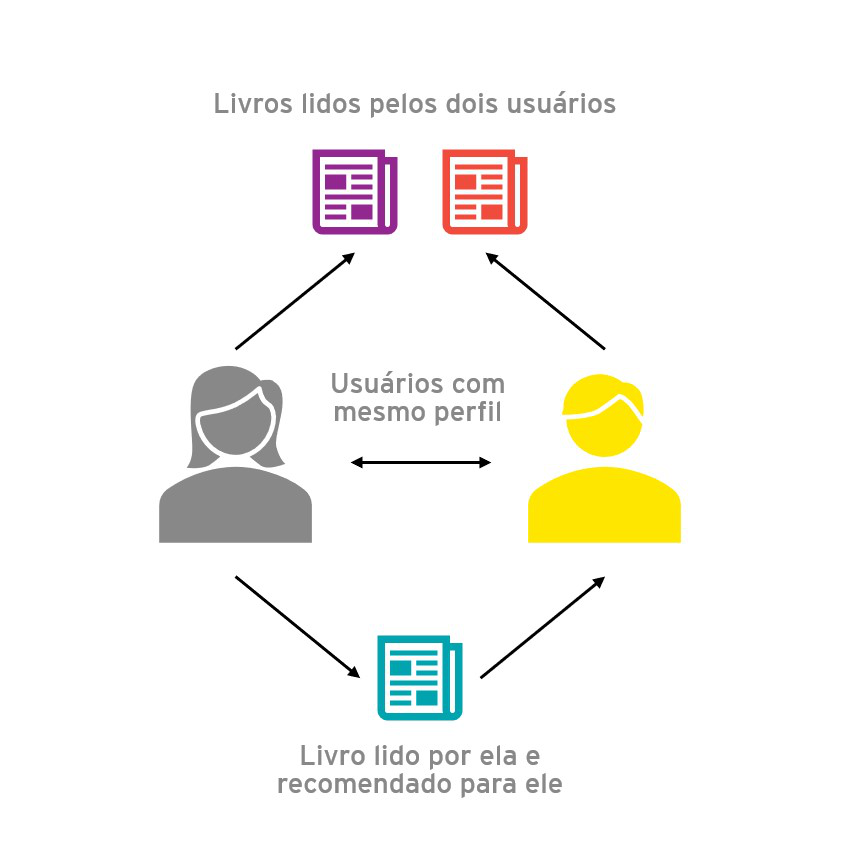

In [77]:
img = Image.open('img/ey-bm-recomendacao1v2.jpg');img

Fonte: https://www.ey.com/pt_br/strategy-transactions/ey-business-modeling-data-analytics/modelo-de-recomendacao-de-produtos1

### Matriz de Usuário x Item

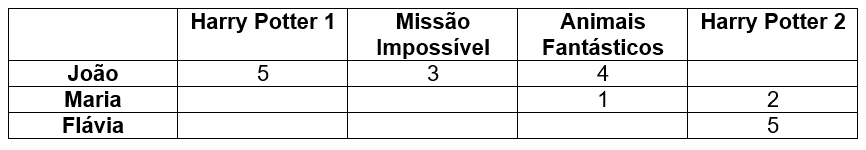

In [79]:
img2 = Image.open('img/usuario_item.png');img2


Fonte: https://www.sidi.org.br/introducao-aos-sistemas-de-recomendacao/

In [80]:
book_pivot = final_rating.pivot_table(columns='user-id', index= 'title', values= 'rating' );
book_pivot

user-id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


Observamos uma grande quantidade de valores `NAN`, pois diversos usuários não tiveram a oportunidade de ler alguns livros

Decidi definir a ausência de avaliação como nota 0

In [81]:
book_pivot.fillna(0, inplace=True);book_pivot

user-id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Em casos onde temos matrizes com uma elevada quantidade de valores 0, o ideal é transforma-la em uma matriz esparsa, a fim de melhorar o tempo de execução e armazenamento

https://acervolima.com/como-criar-uma-matriz-esparsa-em-python/

In [82]:
book_user = csr_matrix(book_pivot);
book_user

<703x888 sparse matrix of type '<class 'numpy.float64'>'
	with 14507 stored elements in Compressed Sparse Row format>

# Modelagem 

In [83]:
model = NearestNeighbors(algorithm='brute')
model.fit(book_user)

NearestNeighbors(algorithm='brute')

Este algorítimo retorna 2 valores, distância e sugestão

# Predições
Passamos para o `model.kneighbors()` o elemento que queremos analizar identificado pela linha

## NearestNeighbors 

In [84]:
titulo = 0 # linha na tabela `book_pivot` que representa o título, neste caso o livro 1984

In [85]:
distance,suggestions = model.kneighbors(book_pivot.iloc[titulo,:].values.reshape(1,-1))

In [86]:
for i in range(len(suggestions)):
    print(f'Para o livro {(book_pivot.index[suggestions[i]])[0]}: você também vai gostar de : {list(book_pivot.index[suggestions[i]][1:])}')

Para o livro 1984: você também vai gostar de : ['No Safe Place', 'A Civil Action', "Foucault's Pendulum", 'Long After Midnight']


In [87]:
def recommend_nn(book_name):
    index = np.where(book_pivot.index==book_name)[0][0] #obtendo o nome do livro
    distance , suggestions = model.kneighbors(book_pivot.iloc[index,:].values.reshape(1,-1),n_neighbors=6) #6 vizinhos mais próximos
    
    for i in range(len(suggestions)):
        books = book_pivot.index[suggestions[i]]
        print(f'Você leu: {book_name}, também vai gostar de:')
        for j in books[1:]:
            print(j)

In [88]:
recommend_nn('The Da Vinci Code')

Você leu: The Da Vinci Code, também vai gostar de:
Touching Evil
The Blue Nowhere : A Novel
Saving Faith
Zoya
Sea Glass: A Novel


## Similaridade dos cosenos

In [89]:
similarity_score = cosine_similarity(book_user)

In [90]:
def recommend_sc(book_name):
    index = np.where(book_pivot.index==book_name)[0][0]
    similar_books = sorted(list(enumerate(similarity_score[index])),key=lambda x:x[1], reverse=True)[1:6]
    
    data = []
    
    for i in similar_books:
        item = []
        temp_df = books[books['title'] == book_pivot.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('title')['title'].values))
        item.extend(list(temp_df.drop_duplicates('title')['author'].values))
        item.extend(list(temp_df.drop_duplicates('title')['Image-URL-L'].values))
        
        data.append(item)
        #for j in data:
         #   print(j)
    msg = f'Você leu {book_name}, também vai gostar de:'
        
        
    return msg, data

In [91]:
recommend_sc('The Da Vinci Code')

('Você leu The Da Vinci Code, também vai gostar de:',
 [['Angels &amp; Demons',
   'Dan Brown',
   'http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg'],
  ['Touching Evil',
   'Kay Hooper',
   'http://images.amazon.com/images/P/0553583441.01.LZZZZZZZ.jpg'],
  ['Middlesex: A Novel',
   'Jeffrey Eugenides',
   'http://images.amazon.com/images/P/0312422156.01.LZZZZZZZ.jpg'],
  ['The Blue Nowhere : A Novel',
   'Jeffery Deaver',
   'http://images.amazon.com/images/P/0671042262.01.LZZZZZZZ.jpg'],
  ["The Sweet Potato Queens' Book of Love",
   'JILL CONNER BROWNE',
   'http://images.amazon.com/images/P/0609804138.01.LZZZZZZZ.jpg']])

# Persistência do modelo


In [92]:
book_name = book_pivot.index

In [93]:
import pickle
pickle.dump(model,open('models/model.pkl','wb'))
pickle.dump(book_name,open('models/book_name.pkl','wb'))
pickle.dump(book_pivot,open('models/book_pivot.pkl','wb'))
pickle.dump(final_rating,open('models/final_rating.pkl','wb'))
